# Dreamclinic Client Churn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime as dt
from sklearn.linear_model import LogisticRegression

In [92]:
client_df = pd.read_excel("~/dales_work/clinic_services_8-1-2016_to_8-3-2019.xlsx")


In [93]:
client_df.drop('Name_Full', axis=1, inplace=True)

In [95]:
# remove rows where HrsWorked = 0 because they are just used by the front desk 
# staff
client_df  = client_df[client_df['HrsWorked'] != 0]

# fill NaN values in 'Service_Category with 'Massage'
client_df['Service_Category'].fillna(value='Massage', inplace=True)

# remove white space from Therapist names
client_df['Therapist'] = client_df['Therapist'].str.strip()

# make all therapist names lowercase to avoid typos in data entry
client_df['Therapist'] = client_df['Therapist'].str.lower()

# find and replace nicknames with domain knowledge
client_df = client_df.replace('abby thomson', 'abigail thomson')

#Drop Address_City and Addres_State Columns from Dataframe
client_df.drop(['Address_City', 'Address_State', 'Invoice_Category'], axis=1, inplace=True)

# Drop rows without a clientID
client_df.dropna(subset=['clientID'], inplace=True)

In [96]:
client_df.head()

,TransactionDate,clientID,Therapist,Address_Zip,Service_Category,HrsWorked
0,2016-08-02,40156.0,michael jacobus,98109,Massage,1.0
1,2016-08-02,60005.0,lauren anderson,98119,Massage,1.0
2,2016-08-02,43420.0,stefanie smith,98144,Massage,1.0
3,2016-08-02,56100.0,elizabeth panelo,98203,Massage,1.0
4,2016-08-02,57367.0,daniel cook,98115,Massage,1.0


In [ ]:
#Order TransactionDate column by month
months = client_df.TransactionDate.dt.to_period("M")

g = client_df.groupby(months)

In [98]:
#Count unique clients by month and drop/rename columns to reflect new aggredated DateFrame
client_count_df = g.nunique() 

client_count_df.drop('TransactionDate', axis=1, inplace= True)

client_count_df.reset_index(inplace=True)

client_count_df["client_count"] = client_count_df['clientID']

client_count_df.drop('clientID', axis=1, inplace=True)

client_count_df['TransactionDate'] = client_count_df['TransactionDate'].astype('str')

client_count_df.rename(columns={"clientID" : "unique_client_count", 
                                   "Therapist" : "therapists_employed", 
                                   "Zipcode" :"zipcodes_reached"}, inplace=True)



client_count_df.drop(["Invoice_Category", "HrsWorked"], axis=1, inplace=True)

client_count_df.drop(['Service_Category'],axis=1,  inplace=True)

# Graph of unique client counts per month from August, 2016

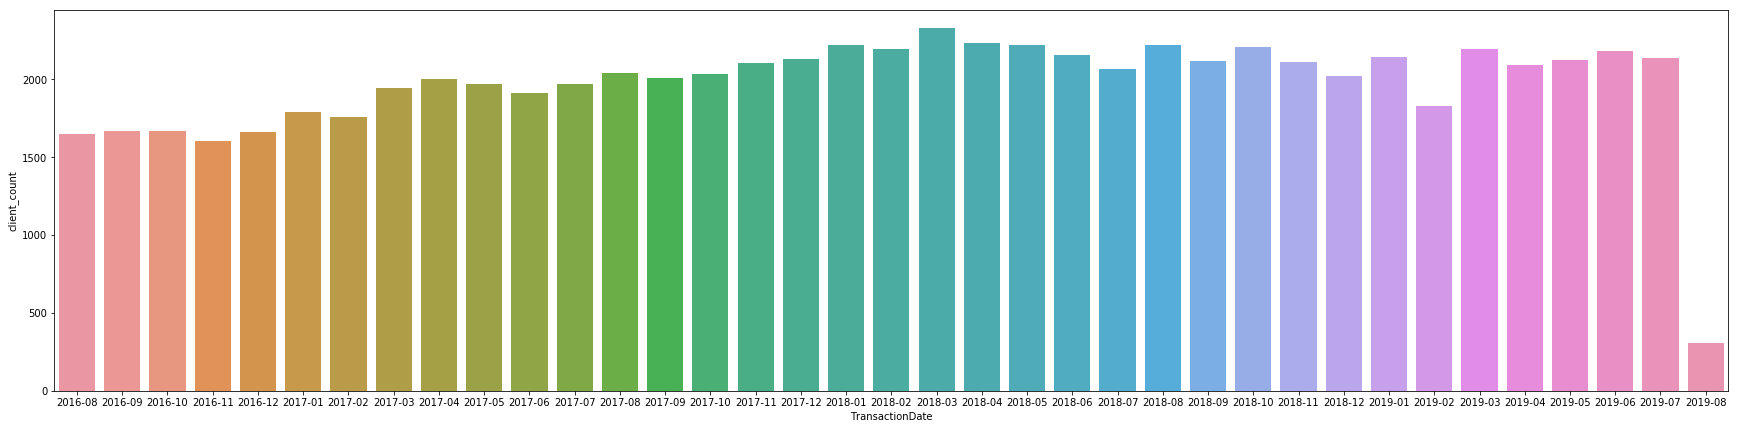

In [101]:
# the dip in Febuary of 2019 is explained by the 1 week snow closure of Seattle
x = client_count_df['TransactionDate']
y = client_count_df['client_count']


fig, ax = plt.subplots(figsize=(30,7))
sns.barplot(x= client_count_df['TransactionDate'], 
             y= client_count_df['client_count'],
             ax=ax);


In [102]:
#Count total services given by month and drop/rename columns to reflect new aggredated DateFrame
service_given_df = g.count()

service_given_df.drop(['TransactionDate', 'Address_Zip'], axis=1, inplace=True)

service_given_df.reset_index(inplace=True)

service_given_df.rename(columns={'clientID': 'services_performed'}, inplace=True)

services_given_df = service_given_df[["TransactionDate", "services_performed"]]


services_given_df = services_given_df.rename(columns={"TransactionDate" : "month"})

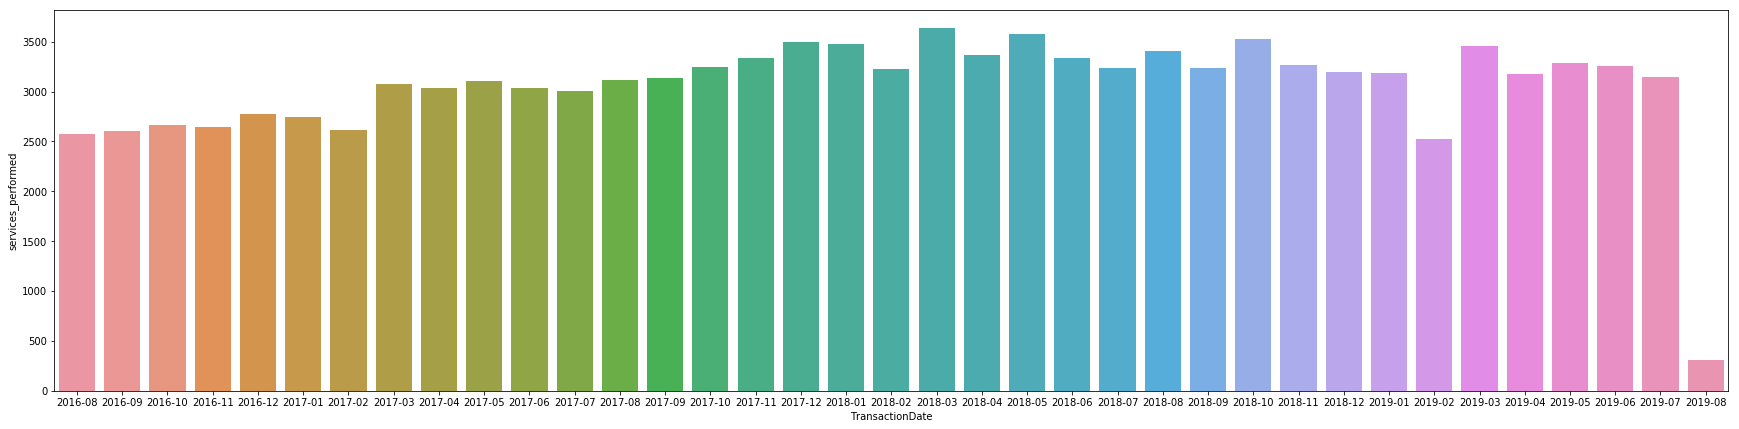

In [103]:
x = services_given_df['month']
y = services_given_df['services_performed']


fig, ax = plt.subplots(figsize=(30,7))
sns.barplot(x= service_given_df['TransactionDate'], 
             y= service_given_df['services_performed'],
             ax=ax);

# How many sessions did the average client from 2016-08 to 2019-08 receive?

In [26]:
session_count = client_df.groupby('clientID').nunique()['TransactionDate']

The average number of sessions a client recieves is ~5.5.

The highest number of massages received is 175 by the CEO of the company


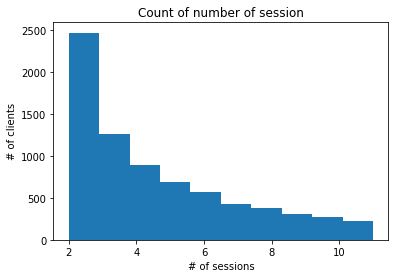

In [106]:
fig, ax = plt.subplots()
ax.hist(session_count, bins=10, range=(2,11))
plt.ylabel('# of clients')
plt.xlabel('# of sessions')
plt.title('Count of number of session');

## The average client get 5.5 sessions and sees 2.5 different therapists.
## People tend to get 1.25 hour sessions which is almost split between the 1h and 1.5h offerings we have.

In [28]:
client_df.groupby('clientID').nunique().mean()

TransactionDate     5.567647
clientID            1.000000
Therapist           2.577686
Address_Zip         0.920891
Invoice_Category    1.090646
Service_Category    1.075064
HrsWorked           1.242721
dtype: float64

# Mark Clients with Churned or Not Churned for further modeling

In [ ]:
# last 2 months of unique client ids
client_df['clientID'].unique()

In [ ]:
client_df.info()

In [29]:
#cuts the data temporally to the last 2 months so that we can label the data for modeling
start = client_df['TransactionDate'].searchsorted(dt.datetime(2019, 6, 1))
end = client_df['TransactionDate'].searchsorted(dt.datetime(2019, 8, 1))

In [30]:
#DataFrame used as labeling data
not_churn_df = client_df.iloc[start:end]

not_churn_df['churn'] = False

labeling_df = pd.DataFrame(not_churn_df['clientID'].unique())

labeling_df['churn'] = False

labeling_df.rename({0 : 'clientID'},axis=1, inplace=True)

labeling_df.columns

churn_df = client_df.merge(labeling_df, how='left', on='clientID')

In [44]:
churn_df.isna().sum()

TransactionDate         0
clientID                0
Therapist               1
Address_Zip          2244
Invoice_Category        0
Service_Category        0
HrsWorked               0
churn               65937
dtype: int64

In [47]:
churn_df['churn'].fillna(value=True, inplace=True)

In [48]:
churn_df.head()

,TransactionDate,clientID,Therapist,Address_Zip,Invoice_Category,Service_Category,HrsWorked,churn
0,2016-08-02,40156.0,michael jacobus,98109,Clinic_Ins,Massage,1.0,True
1,2016-08-02,60005.0,lauren anderson,98119,Clinic_CA,Massage,1.0,False
2,2016-08-02,43420.0,stefanie smith,98144,Clinic_Ins,Massage,1.0,False
3,2016-08-02,56100.0,elizabeth panelo,98203,Clinic_Ins,Massage,1.0,False
4,2016-08-02,57367.0,daniel cook,98115,Clinic_Ins,Massage,1.0,True


In [49]:
churn_df.shape

(113021, 8)

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
# Temporal test split
start = churn_df['TransactionDate'].searchsorted(dt.datetime(2018, 12, 1))
end = churn_df['TransactionDate'].searchsorted(dt.datetime(2019, 5, 31))
test_df = churn_df.iloc[start:end]


In [52]:
#Temporal train split
end = churn_df['TransactionDate'].searchsorted(dt.datetime(2018, 11, 30))
train_df = churn_df.iloc[:end]

In [53]:
train_df['clientID'].unique()

weeds_df = train_df.groupby('clientID').nunique()

weeds_train_df = weeds_df[['TransactionDate', 'Therapist', 'Service_Category']]

In [54]:
weeds_train_df.head()

,TransactionDate,Therapist,Service_Category
clientID,,,
1001.0,140,106,3
1030.0,1,1,1
1065.0,1,1,1
1073.0,3,2,1
1075.0,2,2,1


In [56]:
test_df['clientID'].unique()

weeds_test_df = test_df.groupby('clientID').nunique()

weeds_test_df = weeds_test_df[['TransactionDate', 'Therapist', 'Service_Category']]

In [57]:
churn_df_id_churn = churn_df[['clientID', 'churn']]

In [58]:
# churn or not df for all client IDS, useful for merging
churn_df_id_churn.drop_duplicates(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [59]:
weeds_test_df.shape

(6034, 3)

In [60]:
test_merge_df = weeds_test_df.merge(churn_df_id_churn, how='inner', right_on='clientID', left_index=True)

test_merge_df.reset_index(inplace=True)

test_merge_df.drop('index', axis=1, inplace=True)

In [61]:
test_merge_df.head()

,TransactionDate,Therapist,Service_Category,clientID,churn
0,16,14,1,1001.0,False
1,1,1,1,1030.0,True
2,2,2,1,1073.0,True
3,3,3,1,1075.0,False
4,1,1,1,1338.0,True


In [62]:
train_merge_df = weeds_train_df.merge(churn_df_id_churn, how='inner', right_on='clientID', left_index=True)

train_merge_df.reset_index(inplace=True)


train_merge_df.drop('index', axis=1, inplace=True)

train_target = train_merge_df['churn']

In [ ]:
train_merge_df.head()

In [63]:
X_train = train_merge_df[['TransactionDate', 'Therapist', 'Service_Category', 'clientID']]
y_train = train_merge_df['churn']
X_test =  test_merge_df[['TransactionDate', 'Therapist', 'Service_Category', 'clientID']]
y_test = test_merge_df['churn']

In [64]:
log_reg = LogisticRegression()

In [65]:
log_reg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [69]:
# first model is barely better then just guessing the mean
log_reg.score(X_test, y_test)

0.674842558833278

In [66]:

y_test.mean()

0.6710308253231687

In [89]:
X_prob = log_reg.predict_proba(X_test)[:, -1]

In [70]:
from sklearn.metrics import roc_auc_score, roc_curve

In [76]:
roc_auc_score(y_test, log_reg.predict(X_test))

0.5084898905286811

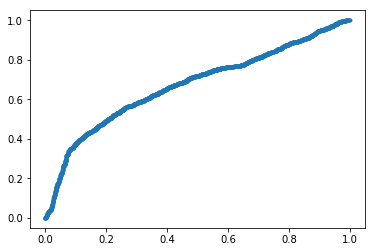

In [90]:
fpr, tpr, thresholds = roc_curve(y_test, X_prob)
plt.plot(fpr, tpr, marker='.')
plt.show();

In [110]:

ten_or_more_ids = session_count[session_count > 9]

In [115]:
ten_or_more_ids = pd.DataFrame([ten_or_more_ids])


In [121]:
ten_or_more_ids = ten_or_more_ids.T

In [122]:
ten_or_more_ids.head()

,TransactionDate
clientID,
1001.0,167
1468.0,23
1690.0,14
1691.0,15
1835.0,53


In [124]:
client_history_10_more_df = client_df.merge(ten_or_more_ids, how='right', left_on='clientID', right_index=True)

In [126]:
client_history_10_more_df.reset_index(inplace=True)

In [127]:
client_history_10_more_df.drop('index', axis=1, inplace=True)

In [131]:
client_history_10_more_df.rename({'TransactionDate_y' : 'session_count', 'TransactionDate_x' : "date"}, axis=1, inplace=True)

In [132]:
client_history_10_more_df

for client, date in client_history_10_more_df:
   

,date,clientID,Therapist,Address_Zip,Service_Category,HrsWorked,session_count
0,2016-08-02,40156.0,michael jacobus,98109,Massage,1.0,20
1,2016-08-19,40156.0,rilla al-haddar,98109,Massage,1.0,20
2,2016-08-26,40156.0,rilla al-haddar,98109,Massage,1.0,20
3,2016-10-05,40156.0,rilla al-haddar,98109,Massage,1.0,20
4,2016-10-28,40156.0,rilla al-haddar,98109,Massage,1.0,20
5,2016-11-04,40156.0,rilla al-haddar,98109,Massage,1.0,20
6,2016-11-11,40156.0,rilla al-haddar,98109,Massage,1.0,20
7,2016-11-21,40156.0,stefanie smith,98109,Massage,1.0,20
8,2017-01-02,40156.0,abigail thomson,98109,Massage,1.0,20
9,2017-01-08,40156.0,dina gosse,98109,Acupuncture,1.0,20


In [138]:
client_history_10_more_df.iloc[0]['clientID']

40156.0

In [139]:
client_history_10_more_df['since_last'] = None

In [157]:
# finds interval lengths for clients who have been in at least 10 times,  O(n) time O(n) space
id = 0
interval = []
for i in range(0, len(client_history_10_more_df)):
    if client_history_10_more_df.iloc[i]['clientID'] == id:
        diff = client_history_10_more_df.iloc[i]['date'] - client_history_10_more_df.iloc[i-1]['date']
        interval.append(diff)
    else:
        id = client_history_10_more_df.iloc[i]['clientID']
        interval.append("First time")

client_history_10_more_df['since_last'] = interval

In [172]:
client_history_10_more_df['since_last'].replace(0, np.nan, inplace=True)

In [185]:
(client_history_10_more_df['since_last']/ np.timedelta64(1, 'D')).astype(int)

0       -9223372036854775808
1                         17
2                          7
3                         40
4                         23
5                          7
6                          7
7                         10
8                         42
9                          6
10                        15
11                         7
12                        14
13                        14
14                         7
15                        21
16                        21
17                        10
18                         6
19                        15
20                        15
21                         7
22                         7
23                         7
24                         7
25                         7
26                        75
27                        16
28                        15
29                         7
                ...         
74809                      2
74810                      2
74811                      1
74812         

In [184]:
client_history_10_more_df.iloc[1]['since_last']

Timedelta('17 days 00:00:00')